In [1]:
%load_ext autoreload
%autoreload 2

from model.autoregressive import ARModel
from model.lorenz96_2param import Lorenz96
from model.parameter import Parameter
from filtering.colkf import ColKF
from filtering.enkf import EnKF
from utils import default_generator
from utils.plotter import Plotter
from utils.compare import Comparator

import numpy as np
import matplotlib.pyplot as plt

Plotter.fig_folder = "figs_cannot_distinguish"

In [2]:
generator = np.random.default_rng(1234)
F = 6.8
b_true = 0.2

forcing = Parameter(
    init_value=F,
    uncertainty=0.5,
    name="$F$",
    estimate=True,
    stochastic_propagation=False,
    stochastic_integration=False,
)
bias = Parameter(
    init_value=b_true,
    uncertainty=0.2,
    name="Bias",
    estimate=True,
    stochastic_propagation=False,
    stochastic_integration=False,
)

D = 20

dt = 0.05
T0 = 0
T = 20
N = 30

x0_unperturbed = generator.normal(size=D)
x0 = x0_unperturbed.copy()
x0 += -2

Q_0 = 0.5 * np.eye(D)
Q_x = lambda _: 0.5 * np.eye(D)
R = lambda _: 1 * np.eye(D)


H = lambda _: np.eye(D)

model = Lorenz96(
    x0_unperturbed,
    dt,
    D,
    forcing,
    bias,
    H,
    Q_x,
    R,
    generator,
    solver="rk4",
    stochastic_integration=False,
    stochastic_propagation=False,
)

times, states = model.integrate(T0, T)
model.reset_model(x0)

# Generate observations with noise
assimilation_step = 1
assimilation_times = np.linspace(1, T, int(T / assimilation_step))
observed = np.zeros((D, len(assimilation_times)))
for i, t in enumerate(assimilation_times):
    k = int(t / dt)
    observed[:, i] = model.observe(states[:, k], add_noise=True)

In [3]:
model.parameters[0].init_value = F - 4
model.parameters[0].current_value = F - 4
model.parameters[1].init_value = 0
model.parameters[1].current_value = 0

model.stochastic_propagation = True

enkf = EnKF(model, x0, Q_0, N, generator=generator, loc_radius=3)
results = enkf.filter(assimilation_times, observed)
results.true_times = times
results.true_states = states
results.figsize = "horizontal"

100%|██████████| 20/20 [00:01<00:00, 13.83it/s]

Localize: True


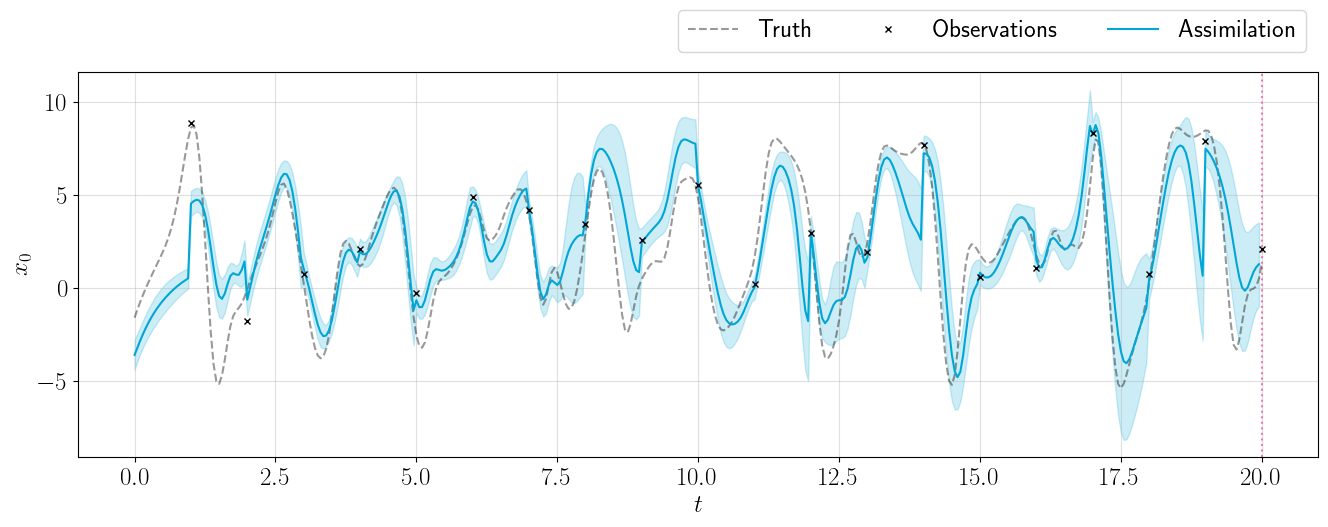

In [4]:
i = 0
results.plot_filtering(i, False, True, path=f"filter_x{i}")
# results.plot_innovations(i, window=3, path=f"innovations_x{i}")

plt.show()

<Axes: xlabel='$t$'>

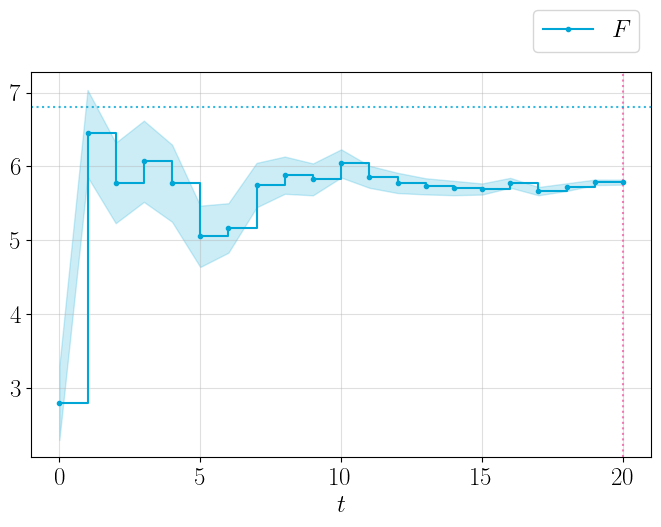

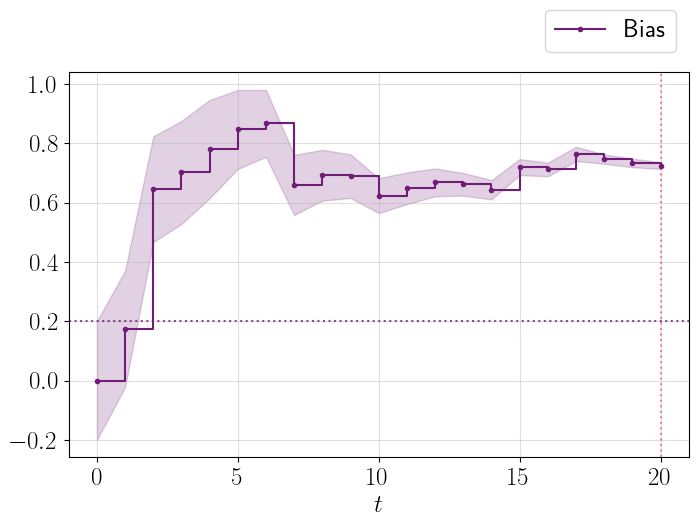

In [5]:
results.plot_params([0], [F])
results.plot_params([1], [b_true])

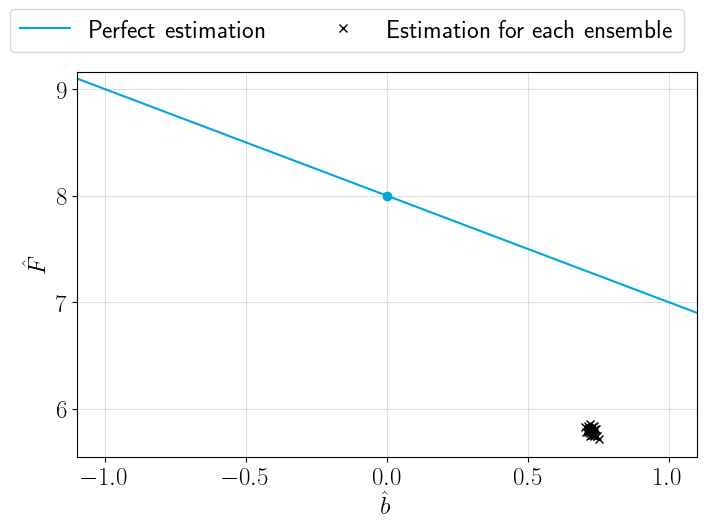

In [6]:
nx = results.model.n_states
Fs = results.full_ensemble_states[nx, :, -1]
bs = results.full_ensemble_states[nx + 1, :, -1]


_, ax = Plotter.subplots(1, 1, "standard")
ax.axline((-1, 9), (1, 7), color=Plotter.color, label="Perfect estimation")
ax.plot(0, 8, "o", color=Plotter.color)
plt.plot(bs, Fs, "kx", label="Estimation for each ensemble", zorder=-1)
ax.set_xlabel("$\\hat{b}$")
ax.set_ylabel("$\\hat{F}$")
Plotter.grid(ax)
Plotter.legend(ax)

<Axes: xlabel='Average innovations per state', ylabel='Frequency'>

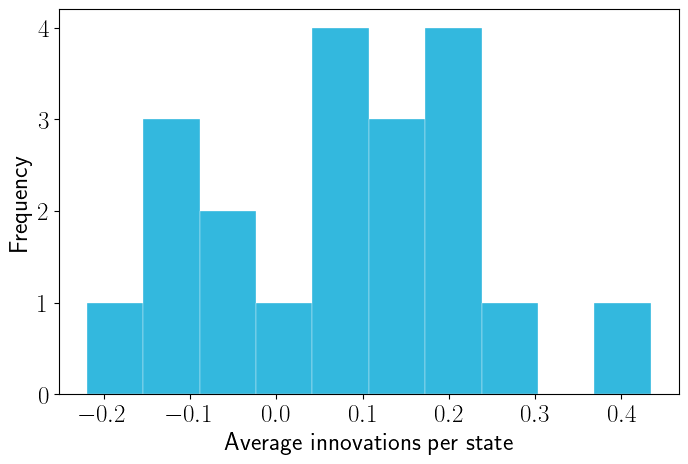

In [7]:
results.plot_av_innovation(alpha=0.8, path="av_inn")

### No feedback

In [8]:
model.parameters[0].init_value = F
model.parameters[0].current_value = F
model.parameters[1].init_value = 0
model.parameters[1].current_value = 0

model.stochastic_integration = True

enkf = EnKF(model, x0, Q_0, N, generator=generator, loc_radius=3)
results = enkf.filter(assimilation_times, observed)
results.true_times = times
results.true_states = states
results.figsize = "horizontal"

100%|██████████| 20/20 [00:02<00:00,  7.78it/s]

Localize: True
